In [ ]:
# import zipfile

# def unzip_file(zip_filepath, extract_dir):
#   with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Vehicle_siren_sound/archive.zip'
# extract_directory = '/content/drive/MyDrive/Colab Notebooks/Vehicle_siren_sound/'

# unzip_file(zip_file_path, extract_directory)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall librosa -y  # Uninstall the current version
!pip install librosa==0.9.2 # Install version 0.9.2

Found existing installation: librosa 0.10.2.post1
Uninstalling librosa-0.10.2.post1:
  Successfully uninstalled librosa-0.10.2.post1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.3 MB/s eta 0:00:00


In [ ]:
#importing libraries
import os
import pickle
import librosa
import numpy as np
import librosa.display
import pandas as pd
import seaborn as sns
from scipy import signal
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
base_directory="/content/drive/MyDrive/sounds"

In [ ]:

def display_audio_waveform(folder,file_name):
  file_path=os.path.join(base_directory,folder,file_name)
  try:
    data, sample_rate = librosa.load(file_path)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(data, sr=sample_rate)
    plt.show()
    ipd.display(ipd.Audio(file_path))

  except FileNotFoundError:
    print(f"Error: File not found at path: {file_path}")
  except Exception as e:
    print(f"An error occurred: {e}")



An error occurred: '_process_plot_var_args' object has no attribute 'prop_cycler'


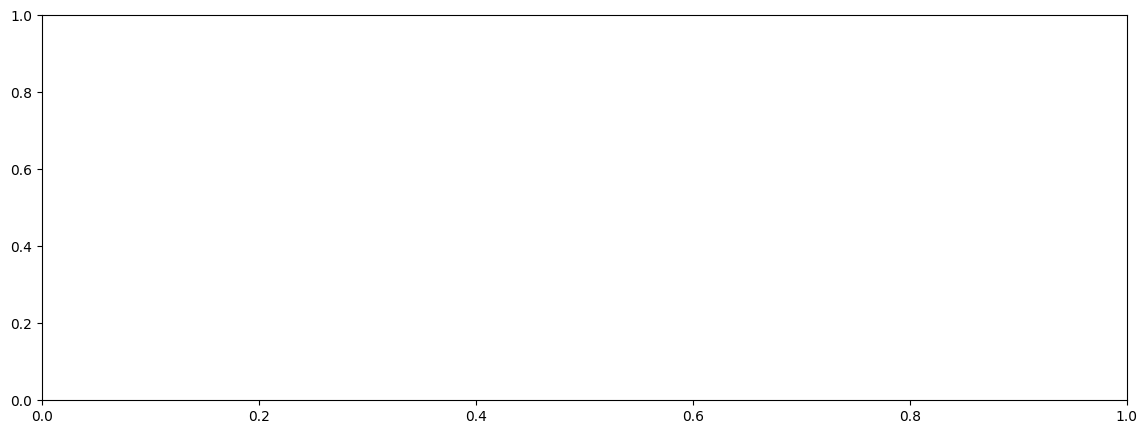

In [ ]:
#evaluvate and explore dataset
folder = "ambulance"
file_name= "sound_1.wav"
display_audio_waveform(folder,file_name)

An error occurred: '_process_plot_var_args' object has no attribute 'prop_cycler'


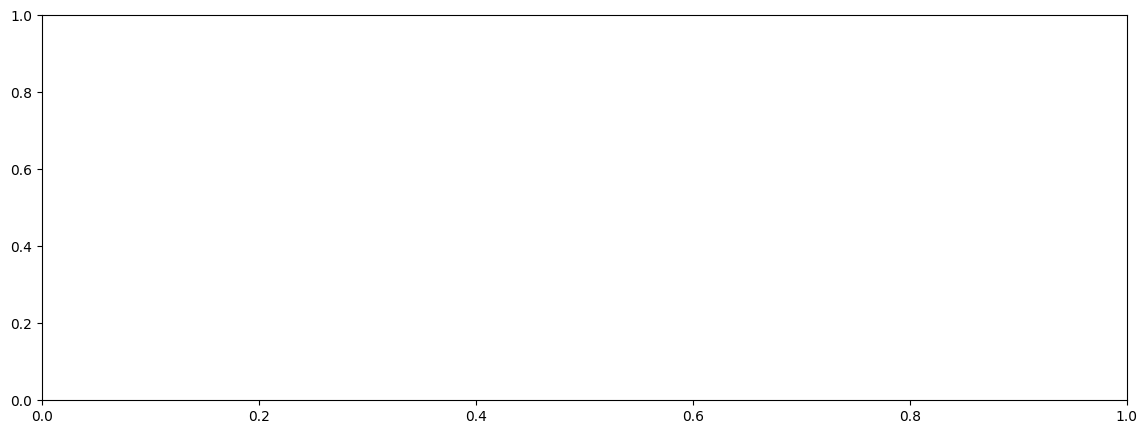

In [ ]:
#evaluvate and explore dataset
folder = "traffic"
file_name= "sound_401.wav"
display_audio_waveform(folder,file_name)

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
#features_extractor to get a 80 MFCCs from each audio

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [ ]:
audio_dataset_path = base_directory

extracted_features = []
for path in os.listdir(audio_dataset_path):
    for file in os.listdir(audio_dataset_path+"/"+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = audio_dataset_path+"/"+path+"/"+file
            data = features_extractor(file_name)
            extracted_features.append([data, path])

In [ ]:
f = open('./Extracted_Features.pkl', 'wb')
pickle.dump(extracted_features, f)
f.close()

In [ ]:
f = open('./Extracted_Features.pkl', 'rb')
Data = pickle.load(f)
f.close()

In [ ]:
df = pd.DataFrame(Data,columns=['feature','class'])
df.head()

,feature,class
0,"[-38.777115, 104.3772, -40.953793, 1.8485571, ...",ambulance
1,"[-118.98806, 113.261086, -38.593113, -1.789974...",ambulance
2,"[-529.2778, 96.09123, -46.660313, -12.780941, ...",ambulance
3,"[-521.1548, 95.068886, -53.56713, -10.641551, ...",ambulance
4,"[-164.77432, 126.585754, -35.331738, -14.7402,...",ambulance


In [ ]:
df['class'].value_counts()

,count
class,
firetruck,206
ambulance,200
traffic,200


In [ ]:
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())

In [ ]:
X.shape

(606, 80)

In [ ]:
Y.shape

(606,)

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(Y))

In [ ]:
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(labelencoder, f)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

In [ ]:
y_train.shape

(484, 3)

# Train the model

In [ ]:
!pip install scikeras

In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime

In [ ]:
X_train_features  = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test),-1,1)
print("Reshaped Array Size", X_train_features.shape)

Reshaped Array Size (484, 80, 1)


In [ ]:
X_train.shape

(484, 80)

In [ ]:
def cnn(optimizer="adam", activation="relu", dropout_rate=0.5):
    K.clear_session()
    inputs = Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))

    #First Conv1D layer
    conv = Conv1D(3, 13, padding='same', activation=activation)(inputs)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='same', activation=activation)(conv)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    #MaxPooling 1D
    conv = GlobalMaxPool1D()(conv)

    #Dense Layer
    conv = Dense(16, activation=activation)(conv)
    outputs = Dense(y_test.shape[1], activation='softmax')(conv)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    return model

In [ ]:
model_cnn = cnn(optimizer="adam", activation="relu", dropout_rate=0)
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 80, 3)               │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 40, 3)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 40, 16)              │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 20, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 909 (3.55 KB)

 Trainable params: 909 (3.55 KB)

 Non-trainable params: 0 (0.00 B)

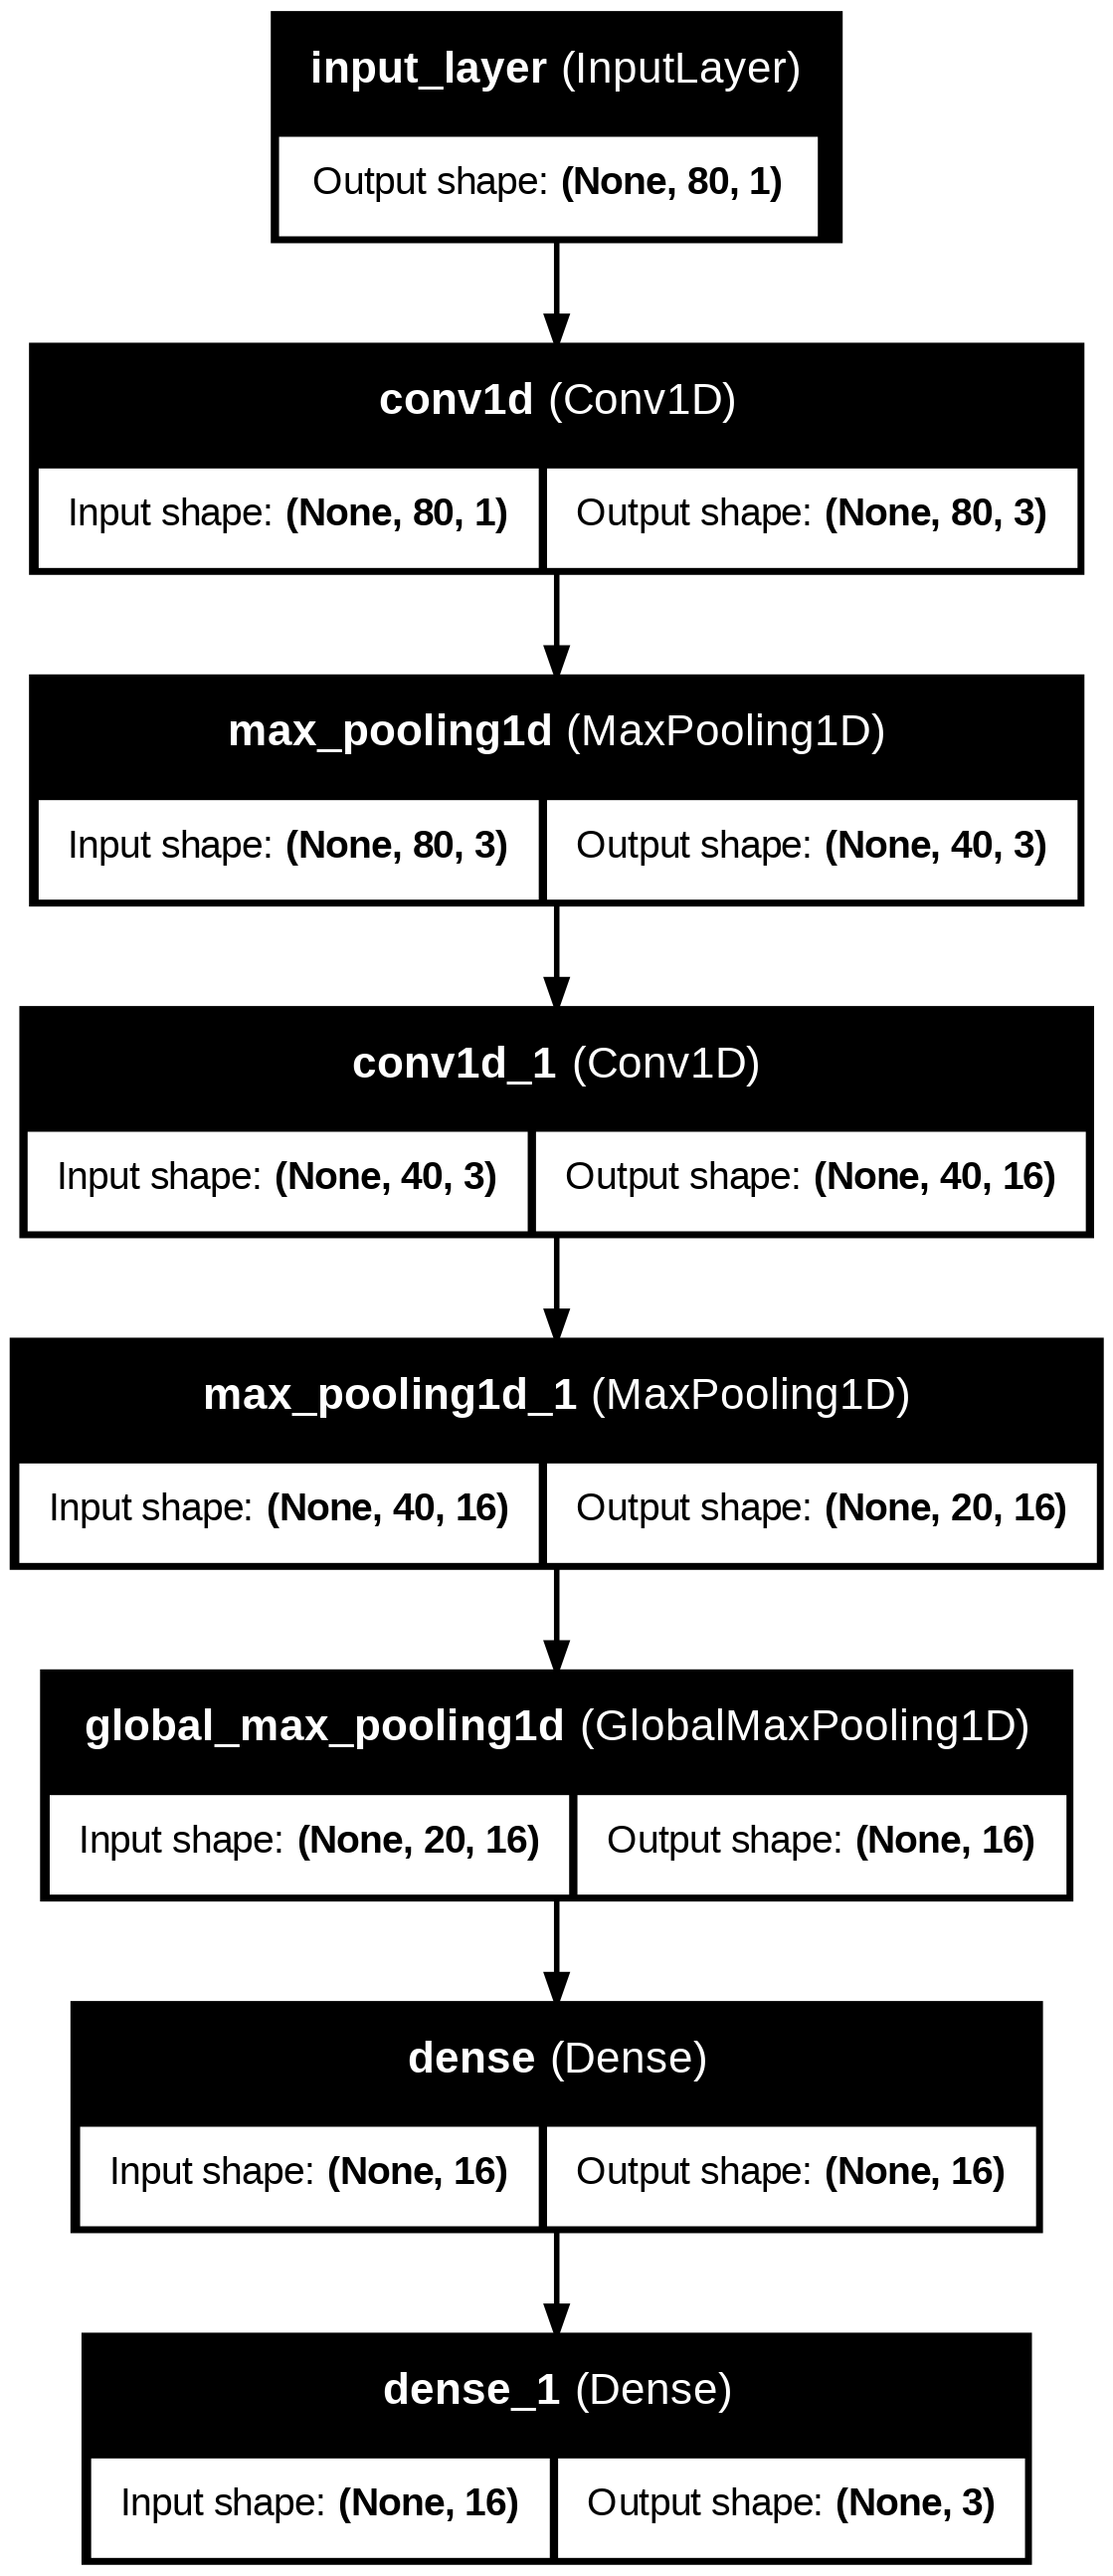

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn, show_shapes=True, show_layer_names=True)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode ='max',
                          patience = 10, restore_best_weights = True)

history = model_cnn.fit(X_train_features, y_train, epochs = 200,
                       callbacks = [early_stop],
                       batch_size = 64, validation_data = (X_test_features, y_test))

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - acc: 0.3410 - loss: 4.1011 - val_acc: 0.3279 - val_loss: 1.5642
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.3592 - loss: 1.3838 - val_acc: 0.2705 - val_loss: 1.1503
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.3011 - loss: 1.0757 - val_acc: 0.3279 - val_loss: 0.8998
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.4863 - loss: 0.7305 - val_acc: 0.6066 - val_loss: 0.5948
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - acc: 0.6168 - loss: 0.5617 - val_acc: 0.6885 - val_loss: 0.5039
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.7149 - loss: 0.4707 - val_acc: 0.7459 - val_loss: 0.4590
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.7950 - loss: 0.4054 - val_acc: 0.7705 - val_loss: 0.4008
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.7832 - loss: 0.3571 - val_acc: 0.7623 - val_loss: 0.3685
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.8209 - loss: 0.3095 - val_acc: 0.7787 - val_loss: 0.3436
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.8458 - loss: 0.2885 - va

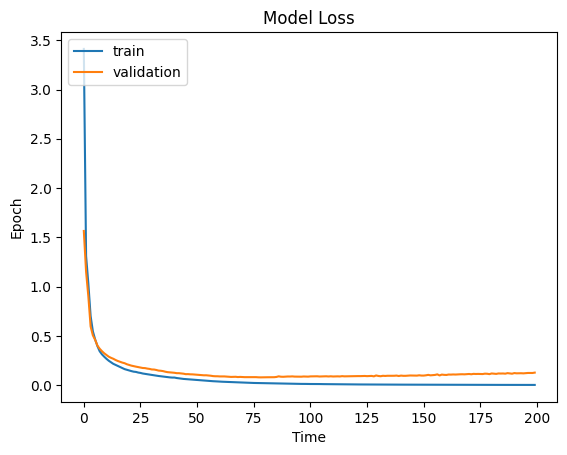

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Time')
plt.ylabel('Epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

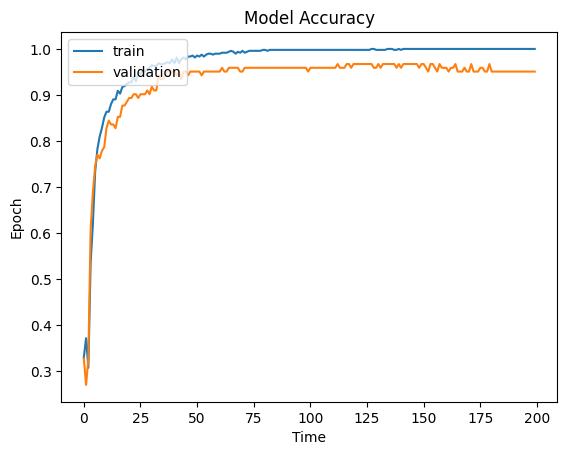

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Time')
plt.ylabel('Epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
_, acc = model_cnn.evaluate(X_test_features, y_test)
print("Test Accuracy : ", acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9480 - loss: 0.1550 
Test Accuracy :  0.9508196711540222


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


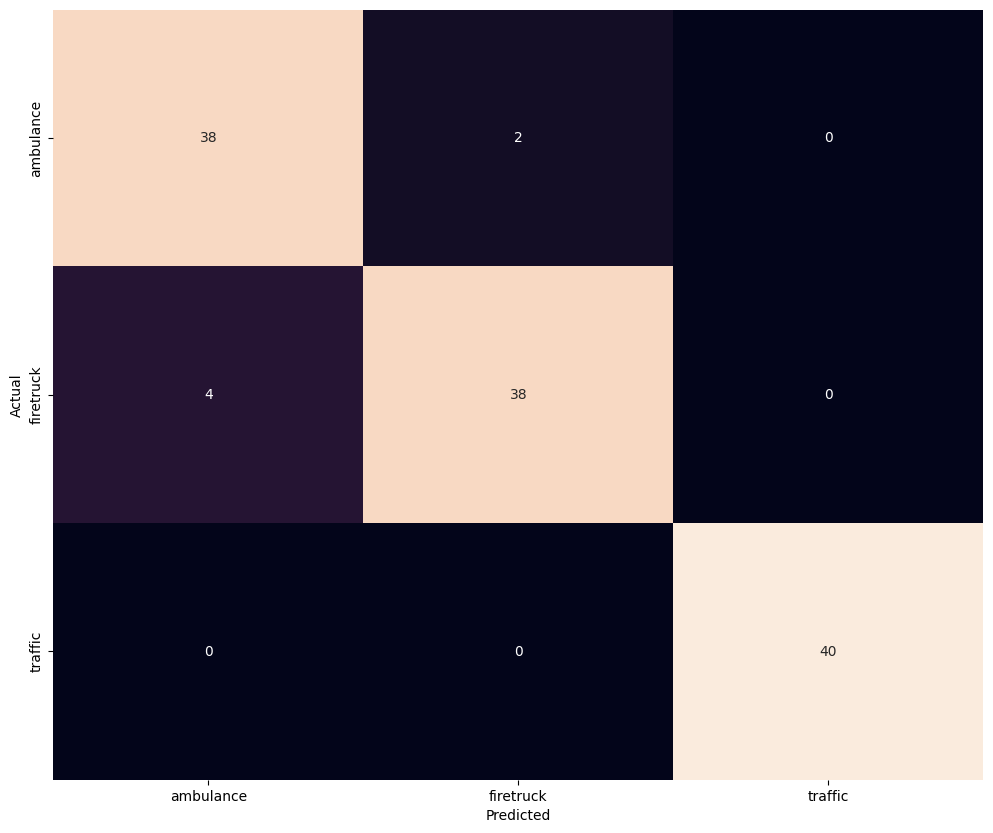

In [ ]:
y_pred = model_cnn.predict(X_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model_cnn.save('cnn_model.h5')

In [ ]:
with open('label_encoder.pkl', 'rb') as f:
    loaded_label_encoder = pickle.load(f)

# Verify it works
print("Loaded classes:", loaded_label_encoder.classes_)

Loaded classes: ['ambulance' 'firetruck' 'traffic']


In [ ]:
# if you want model as function you can use this cell
from flask import Flask, request, jsonify
import numpy as np
import librosa
import pickle
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder


model = load_model('/content/cnn_model.h5')

with open('/content/label_encoder.pkl', 'rb') as f:
   label_encoder = pickle.load(f)

def features_extractor(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

# file = request.files['file']

# if not file.filename.endswith('.wav'):
#     # return jsonify({'error': 'Unsupported file format. Please upload a .wav file'}), 400
#     print("Unsupported file format. Please upload a .wav file")

try:
    # Save the uploaded file
    file_path ="/content/drive/MyDrive/Colab Notebooks/Vehicle_siren_sound/sounds/firetruck/sound_205.wav"
    # file.save(file_path)

    features = features_extractor(file_path)
    features = features.reshape(1, -1, 1)

    # Make prediction
    predictions = model.predict(features)
    predicted_class = np.argmax(predictions, axis=1)
    class_label = label_encoder.inverse_transform(predicted_class)
    print(class_label)
    # return jsonify({'predicted_class': class_label[0]}), 200
    # print("predicted_class:", class_label[0])

except Exception as e:
  print(e)
    # return jsonify({'error': str(e)}), 500

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Vehicle_siren_sound/sounds/firetruck/sound_205.wav'


/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


# LSTM model

In [ ]:
x_train_features  = X_train.reshape(len(X_train),-1, 80)
x_test_features = X_test.reshape(len(X_test), -1, 80)
print("Reshaped Array Size", x_train_features.shape)

Reshaped Array Size (484, 1, 80)


In [ ]:
def lstm(x_tr):
    K.clear_session()
    inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))
    #lstm
    x = LSTM(128)(inputs)
    x = Dropout(0.5)(x)
    #dense
    x = Dense(64, activation='relu')(x)
    x = Dense(y_test.shape[1], activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [ ]:
model_lstm = lstm(x_train_features)
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         107,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,459 (451.01 KB)

 Trainable params: 115,459 (451.01 KB)

 Non-trainable params: 0 (0.00 B)

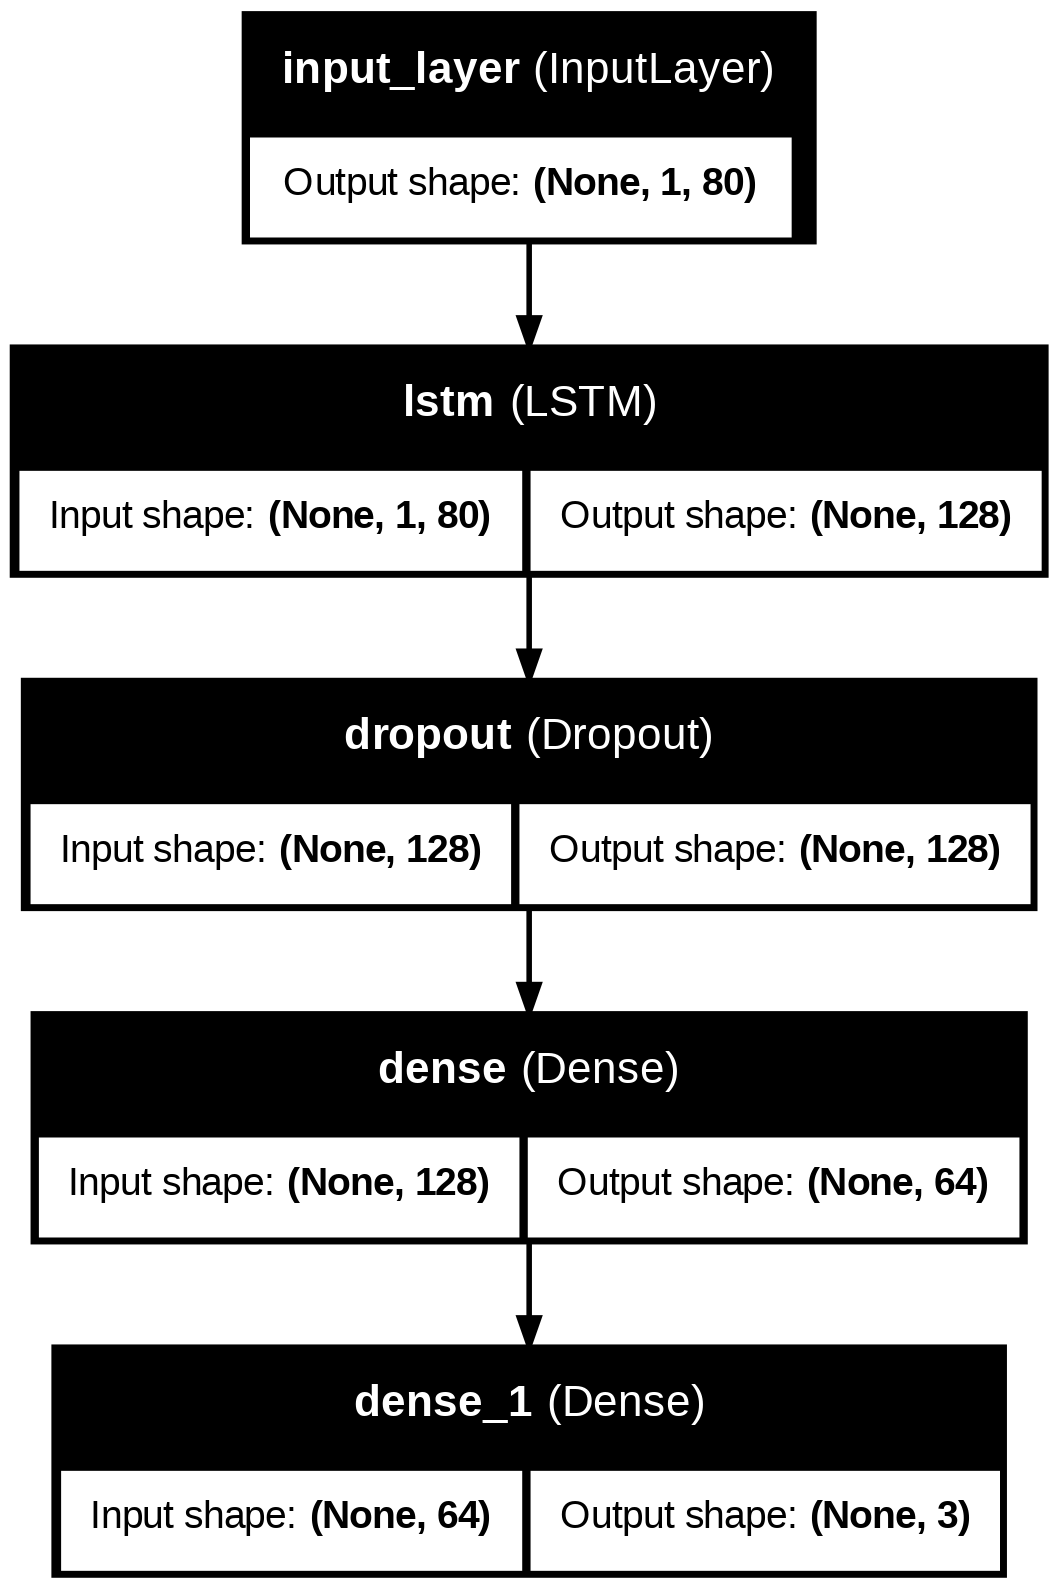

In [ ]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

In [ ]:
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model_lstm.fit(x_train_features, y_train, epochs = 1000,
                        callbacks = [mc],
                        batch_size = 64, validation_data = (x_test_features, y_test))

Epoch 1/1000
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3557 - loss: 0.7276
Epoch 1: val_acc improved from -inf to 0.81967, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - acc: 0.3767 - loss: 0.7146 - val_acc: 0.8197 - val_loss: 0.5263
Epoch 2/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.6875 - loss: 0.5311
Epoch 2: val_acc improved from 0.81967 to 0.84426, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.7395 - loss: 0.5031 - val_acc: 0.8443 - val_loss: 0.3898
Epoch 3/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7812 - loss: 0.4054
Epoch 3: val_acc improved from 0.84426 to 0.86066, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8214 - loss: 0.3828 - val_acc: 0.8607 - val_loss: 0.3004
Epoch 4/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.9219 - loss: 0.2885
Epoch 4: val_acc improved from 0.86066 to 0.89344, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/ste

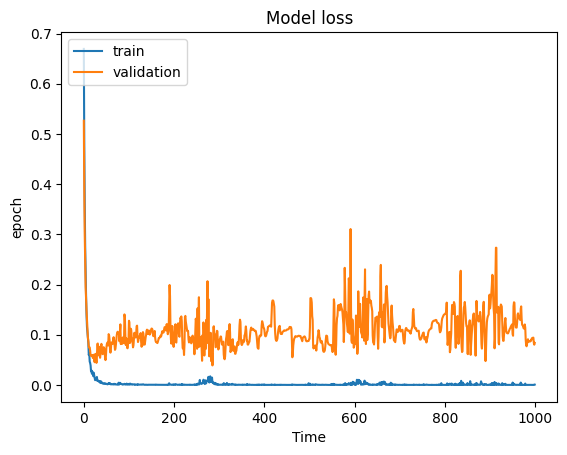

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

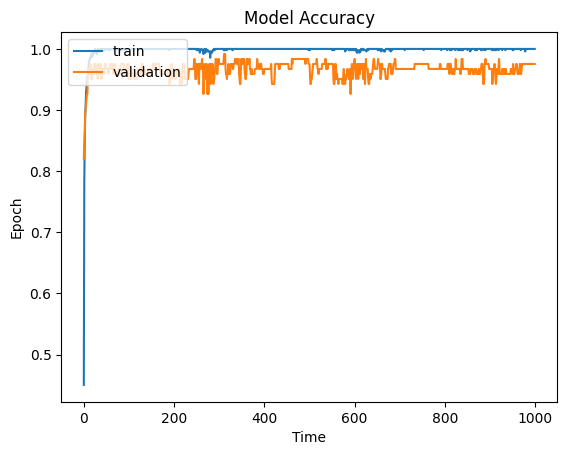

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Time')
plt.ylabel('Epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
_,acc = model_lstm.evaluate(x_test_features, y_test)
print("Accuracy:", acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9735 - loss: 0.1028 
Accuracy: 0.9754098653793335


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


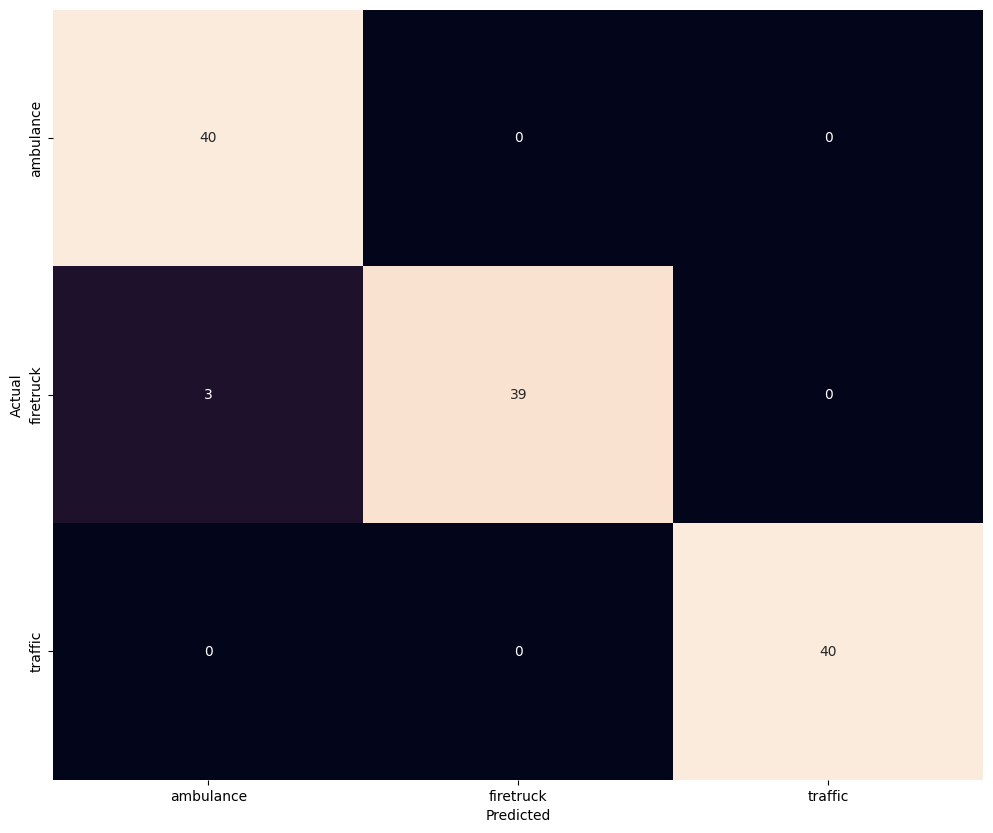

In [ ]:
y_pred = model_lstm.predict(x_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model_lstm.save('lstm_model.h5')